In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['Year'] = df['Year'].apply(lambda x: pd.to_datetime(x.split('-')[0] + '-01-01'))
    df.set_index('Year', inplace=True)
    df = df.dropna(subset=['Area(Hectare)', 'Production(Tonnes)', 'Yield(Tonne/Hectare)'], how='all')
    return df

In [3]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] <= 0.05

In [4]:
def difference_series(series):
    return series.diff().dropna()

In [7]:
def analyze_agricultural_data(state, district, df):
    data = df[(df['State'] == state) & (df['District'] == district)].copy()
    
    if data.empty:
        print(f"No data found for {district}, {state}")
        return None
    
    production = data['Production(Tonnes)']
    
    if len(production) < 10:
        print(f"Warning: Limited data available ({len(production)} points). Some analyses may be limited.")
    
    # Bar plot for historical data
    plt.figure(figsize=(12, 6))
    sns.barplot(x=production.index.year, y=production.values)
    plt.title(f'Rice Production in {district}, {state}')
    plt.xlabel('Year')
    plt.ylabel('Production (Tonnes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nChecking stationarity of original series:")
    is_stationary = check_stationarity(production)
    
    if not is_stationary:
        print("\nTime series is not stationary. Applying differencing.")
        production_diff = difference_series(production)
        d = 1
        while not check_stationarity(production_diff) and d < 2:
            production_diff = difference_series(production_diff)
            d += 1
    else:
        production_diff = production
        d = 0
        print("\nTime series is stationary.")
    
    max_lags = max(1, int(len(production_diff) * 0.3) - 1)
    
    if len(production_diff) > 4:
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            plot_acf(production_diff, ax=ax1, lags=max_lags)
            plot_pacf(production_diff, ax=ax2, lags=max_lags)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\nCould not generate ACF/PACF plots: {str(e)}")
    
    p = min(1, max_lags)
    q = min(1, max_lags)
    
    try:
        model = ARIMA(production, order=(p, d, q))
        results = model.fit()
        
        forecast_steps = 5
        forecast = results.forecast(steps=forecast_steps)
        
        # Scatter plot with trend line for historical data and forecast
        plt.figure(figsize=(12, 6))
        sns.regplot(x=np.arange(len(production)), y=production.values, scatter_kws={'s': 50}, label='Historical')
        
        last_date = production.index[-1]
        future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]
        
        plt.scatter(np.arange(len(production), len(production) + forecast_steps), forecast, color='red', s=50, label='Forecast')
        plt.plot(np.arange(len(production), len(production) + forecast_steps), forecast, color='red', linestyle='--')
        
        plt.title(f'Rice Production Trend and Forecast for {district}, {state}')
        plt.xlabel('Time Steps')
        plt.ylabel('Production (Tonnes)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        if len(production) >= 5:
            train_size = int(len(production) * 0.8)
            train, test = production[:train_size], production[train_size:]
            
            model_test = ARIMA(train, order=(p, d, q))
            results_test = model_test.fit()
            forecast_test = results_test.forecast(steps=len(test))
            
            rmse = np.sqrt(mean_squared_error(test, forecast_test))
            mape = mean_absolute_percentage_error(test, forecast_test) * 100
            
            print("\nModel Performance Metrics:")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2f}%")
        else:
            print("\nInsufficient data for performance metrics calculation")
        
        # Bar and line plot for forecast
        plt.figure(figsize=(12, 6))
        plt.bar(production.index.year, production.values, alpha=0.7, label='Historical')
        plt.plot(future_dates.year, forecast, color='red', marker='o', linestyle='--', linewidth=2, markersize=8, label='Forecast')
        plt.title(f'Rice Production History and Forecast for {district}, {state}')
        plt.xlabel('Year')
        plt.ylabel('Production (Tonnes)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("\nForecast for the next 5 years:")
        for year, value in zip(future_dates, forecast):
            print(f"{year.year}: {value:,.2f} tonnes")
            
    except Exception as e:
        print(f"\nError in model fitting: {str(e)}")
        print("Try adjusting the ARIMA parameters or checking the data quality.")
    
    return data


Loading and preprocessing data...

Agricultural Production Analysis
--------------------------------


Enter the state name:  Arunachal Pradesh
Enter the district name:  Lohit


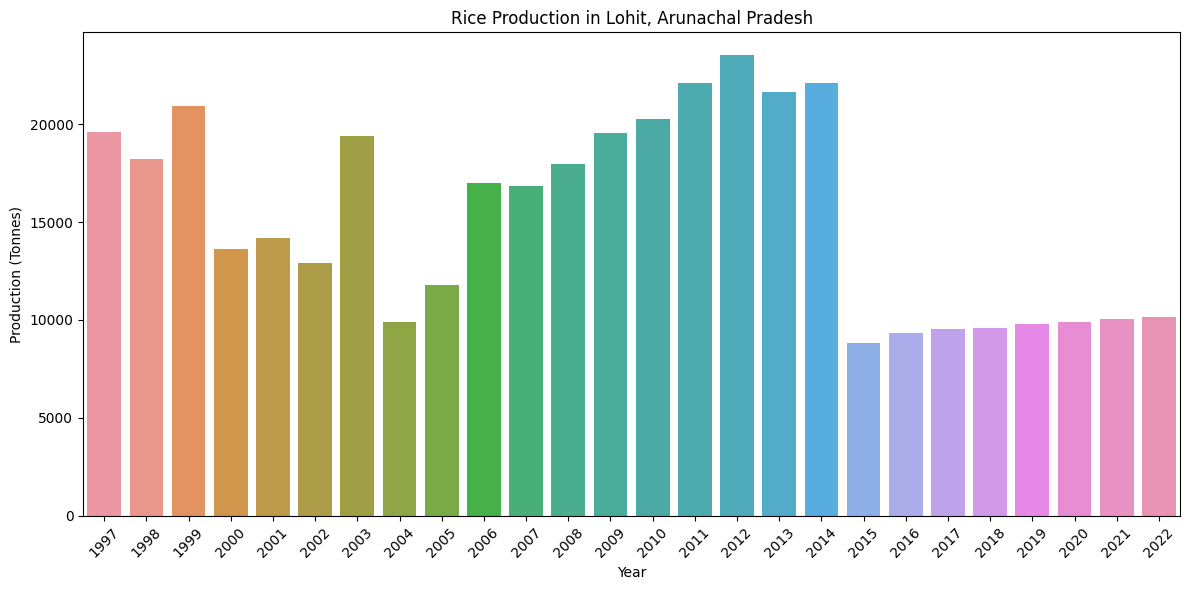


Checking stationarity of original series:

Augmented Dickey-Fuller Test Results:
ADF Statistic: -2.111496135694762
p-value: 0.2399171449681302
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

Time series is not stationary. Applying differencing.

Augmented Dickey-Fuller Test Results:
ADF Statistic: -6.323310184857089
p-value: 3.028718835620696e-08
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


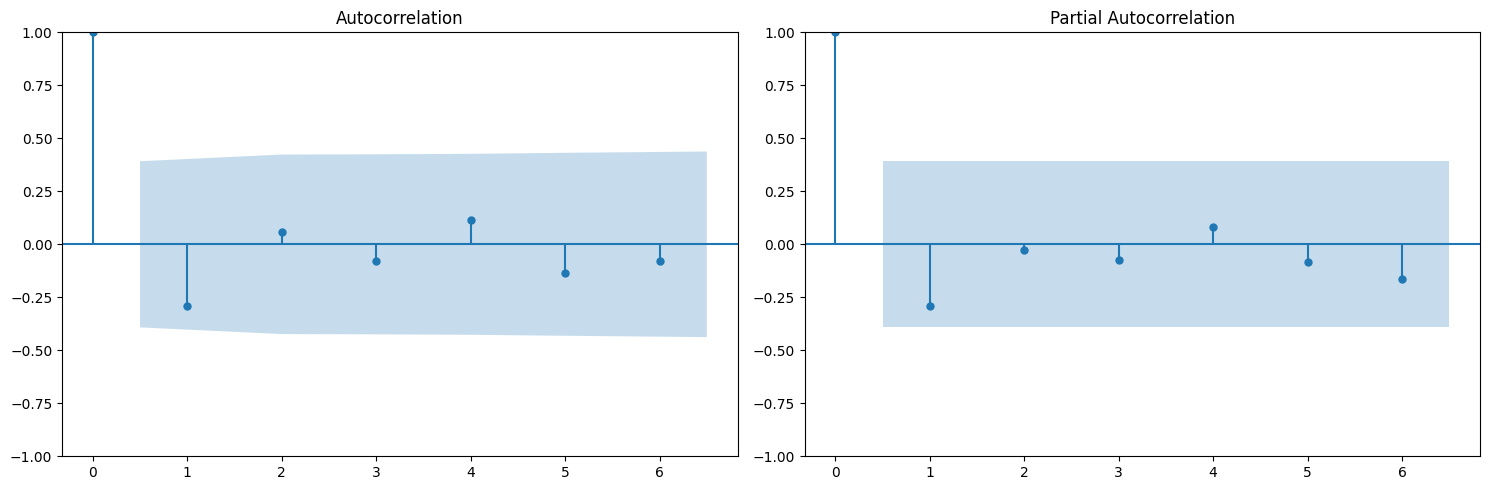

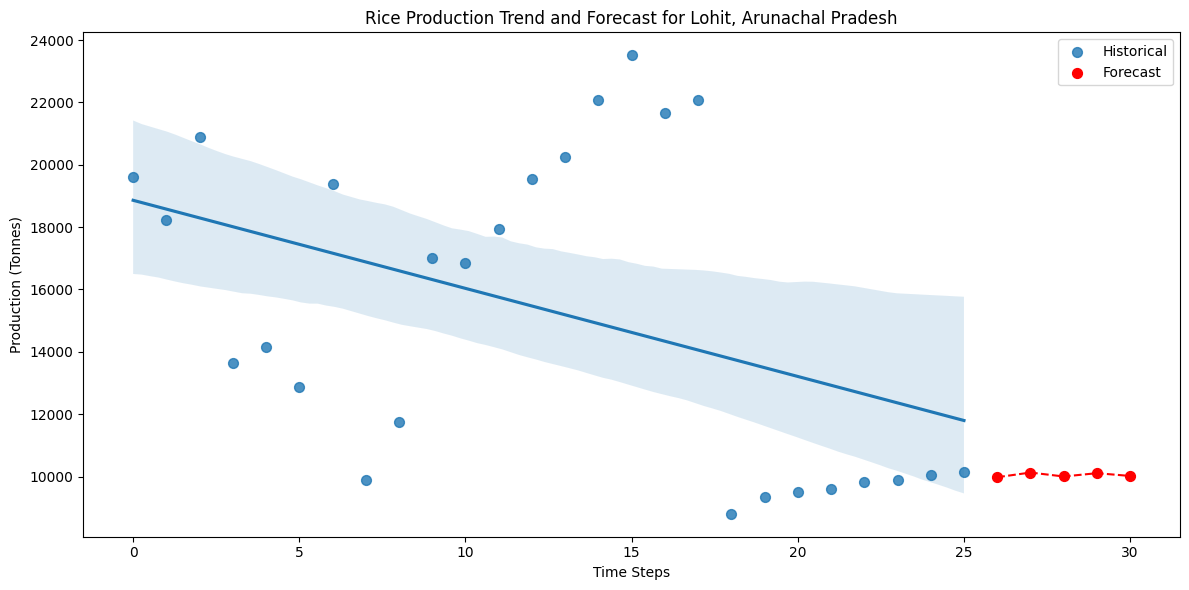


Model Performance Metrics:
RMSE: 1384.47
MAPE: 13.19%


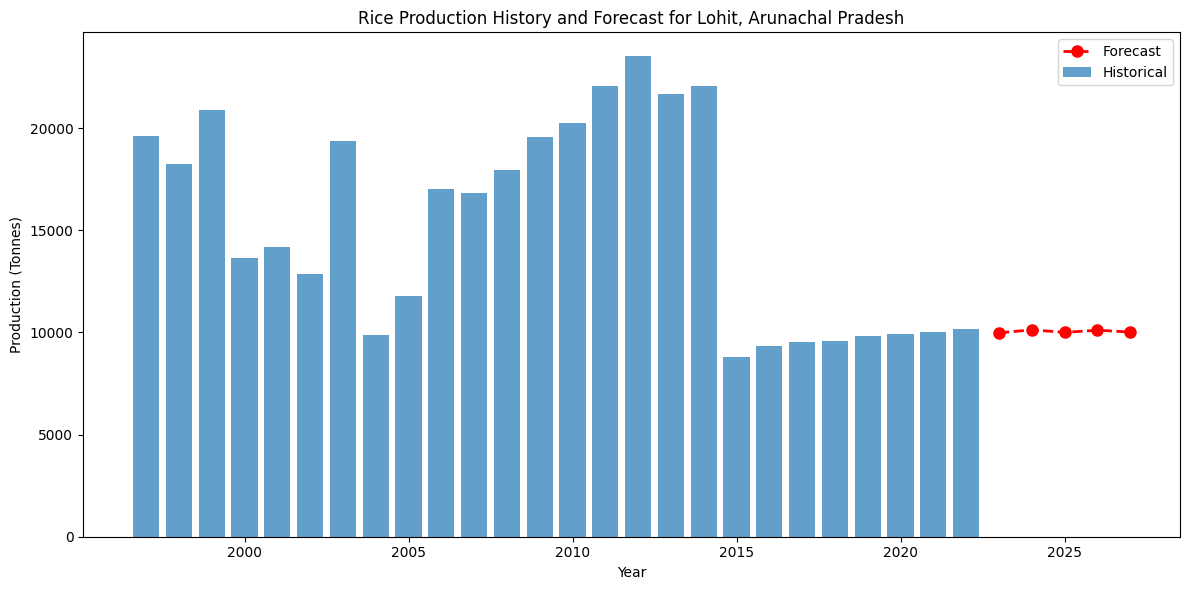


Forecast for the next 5 years:
2023: 9,977.04 tonnes
2024: 10,127.04 tonnes
2025: 10,000.82 tonnes
2026: 10,107.03 tonnes
2027: 10,017.66 tonnes


In [8]:
def main():
    try:
        file_path = "rice.xlsx"  # Replace with your file path
        print("\nLoading and preprocessing data...")
        df = load_and_preprocess_data(file_path)
        
        print("\nAgricultural Production Analysis")
        print("--------------------------------")
        state = input("Enter the state name: ")
        district = input("Enter the district name: ")
        
        data = analyze_agricultural_data(state, district, df)
        
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please check your input data and try again.")

if __name__ == "__main__":
    main()

In [9]:
def analyze_agricultural_data(state, district, df):
    data = df[(df['State'] == state) & (df['District'] == district)].copy()
    
    if data.empty:
        print(f"No data found for {district}, {state}")
        return None
    
    yield_data = data['Yield(Tonne/Hectare)']
    
    if len(yield_data) < 10:
        print(f"Warning: Limited data available ({len(yield_data)} points). Some analyses may be limited.")
    
    # Bar plot for historical yield data
    plt.figure(figsize=(12, 6))
    sns.barplot(x=yield_data.index.year, y=yield_data.values)
    plt.title(f'Rice Yield in {district}, {state}')
    plt.xlabel('Year')
    plt.ylabel('Yield (Tonne/Hectare)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nChecking stationarity of original series:")
    is_stationary = check_stationarity(yield_data)
    
    if not is_stationary:
        print("\nTime series is not stationary. Applying differencing.")
        yield_diff = difference_series(yield_data)
        d = 1
        while not check_stationarity(yield_diff) and d < 2:
            yield_diff = difference_series(yield_diff)
            d += 1
    else:
        yield_diff = yield_data
        d = 0
        print("\nTime series is stationary.")
    
    max_lags = max(1, int(len(yield_diff) * 0.3) - 1)
    
    if len(yield_diff) > 4:
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            plot_acf(yield_diff, ax=ax1, lags=max_lags)
            plot_pacf(yield_diff, ax=ax2, lags=max_lags)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\nCould not generate ACF/PACF plots: {str(e)}")
    
    p = min(1, max_lags)
    q = min(1, max_lags)
    
    try:
        model = ARIMA(yield_data, order=(p, d, q))
        results = model.fit()
        
        forecast_steps = 5
        forecast = results.forecast(steps=forecast_steps)
        
        # Scatter plot with trend line for historical data and forecast
        plt.figure(figsize=(12, 6))
        sns.regplot(x=np.arange(len(yield_data)), y=yield_data.values, scatter_kws={'s': 50}, label='Historical')
        
        last_date = yield_data.index[-1]
        future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='Y')[1:]
        
        plt.scatter(np.arange(len(yield_data), len(yield_data) + forecast_steps), forecast, color='red', s=50, label='Forecast')
        plt.plot(np.arange(len(yield_data), len(yield_data) + forecast_steps), forecast, color='red', linestyle='--')
        
        plt.title(f'Rice Yield Trend and Forecast for {district}, {state}')
        plt.xlabel('Time Steps')
        plt.ylabel('Yield (Tonne/Hectare)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        if len(yield_data) >= 5:
            train_size = int(len(yield_data) * 0.8)
            train, test = yield_data[:train_size], yield_data[train_size:]
            
            model_test = ARIMA(train, order=(p, d, q))
            results_test = model_test.fit()
            forecast_test = results_test.forecast(steps=len(test))
            
            rmse = np.sqrt(mean_squared_error(test, forecast_test))
            mape = mean_absolute_percentage_error(test, forecast_test) * 100
            
            print("\nModel Performance Metrics:")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2f}%")
        else:
            print("\nInsufficient data for performance metrics calculation")
        
        # Bar and line plot for forecast
        plt.figure(figsize=(12, 6))
        plt.bar(yield_data.index.year, yield_data.values, alpha=0.7, label='Historical')
        plt.plot(future_dates.year, forecast, color='red', marker='o', linestyle='--', linewidth=2, markersize=8, label='Forecast')
        plt.title(f'Rice Yield History and Forecast for {district}, {state}')
        plt.xlabel('Year')
        plt.ylabel('Yield (Tonne/Hectare)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("\nYield Forecast for the next 5 years:")
        for year, value in zip(future_dates, forecast):
            print(f"{year.year}: {value:.2f} tonne/hectare")
            
    except Exception as e:
        print(f"\nError in model fitting: {str(e)}")
        print("Try adjusting the ARIMA parameters or checking the data quality.")
    
    return data



Loading and preprocessing data...

Agricultural Yield Analysis
----------------------------


Enter the state name:  Arunachal Pradesh
Enter the district name:  Lohit


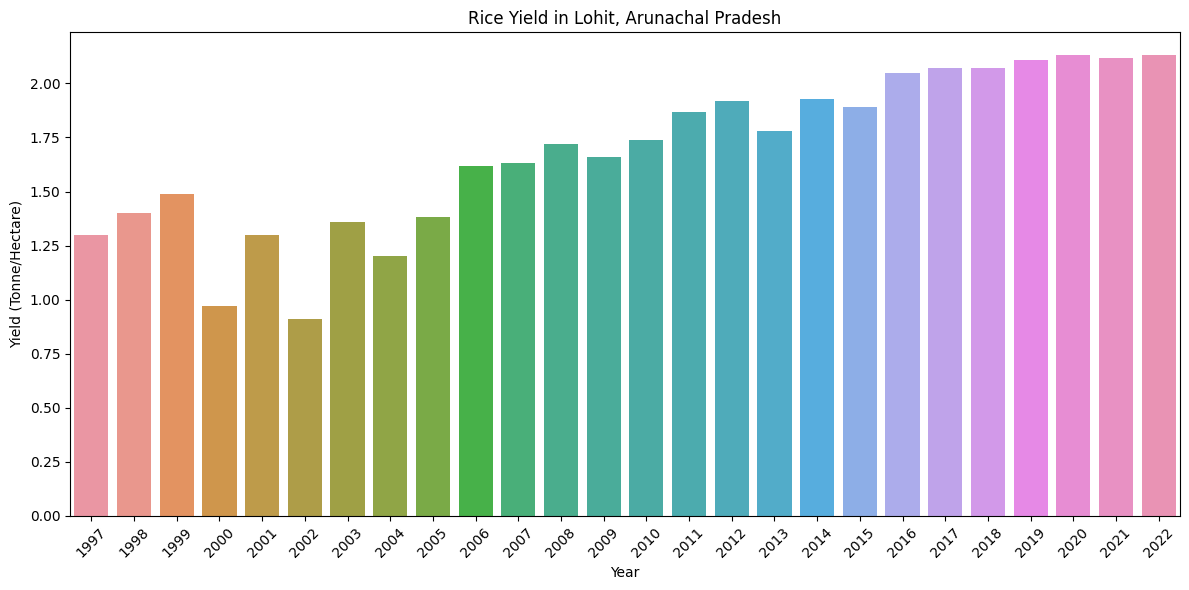


Checking stationarity of original series:

Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.2559648628480289
p-value: 0.6490701188976061
Critical Values:
	1%: -3.9240193847656246
	5%: -3.0684982031250003
	10%: -2.67389265625

Time series is not stationary. Applying differencing.

Augmented Dickey-Fuller Test Results:
ADF Statistic: -10.336169599826817
p-value: 2.760291552112497e-18
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


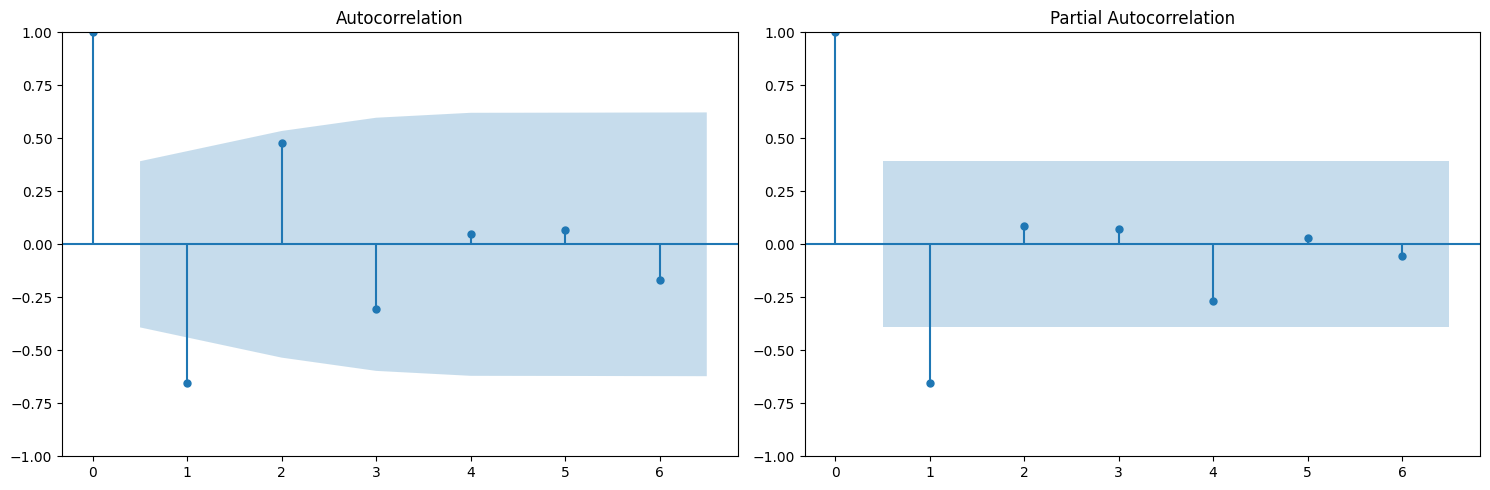

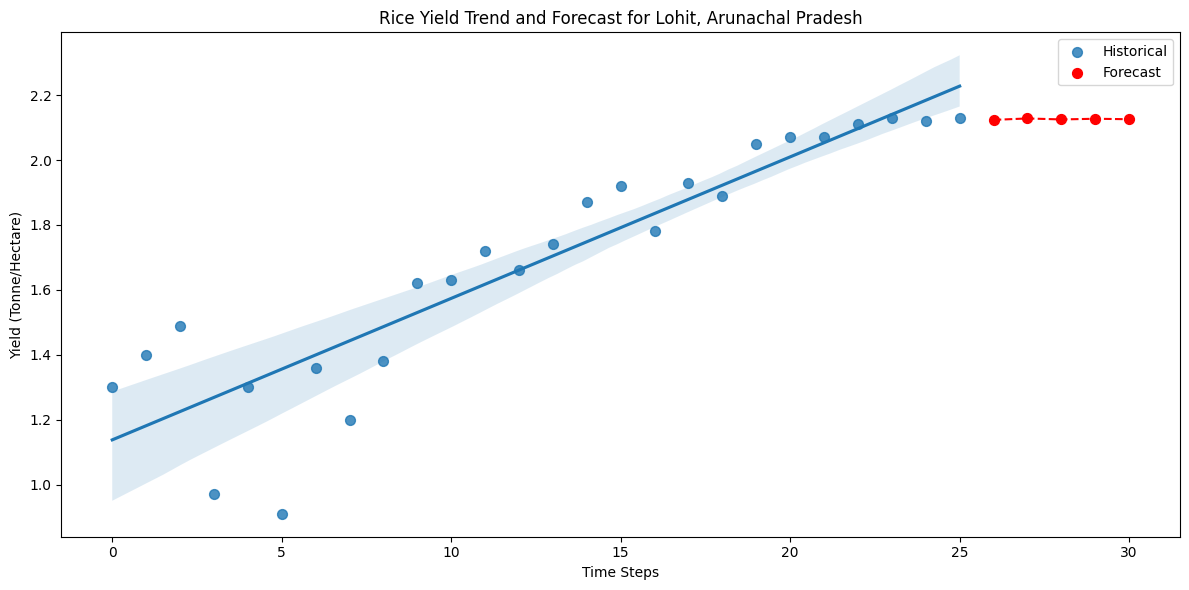


Model Performance Metrics:
RMSE: 0.12
MAPE: 5.37%


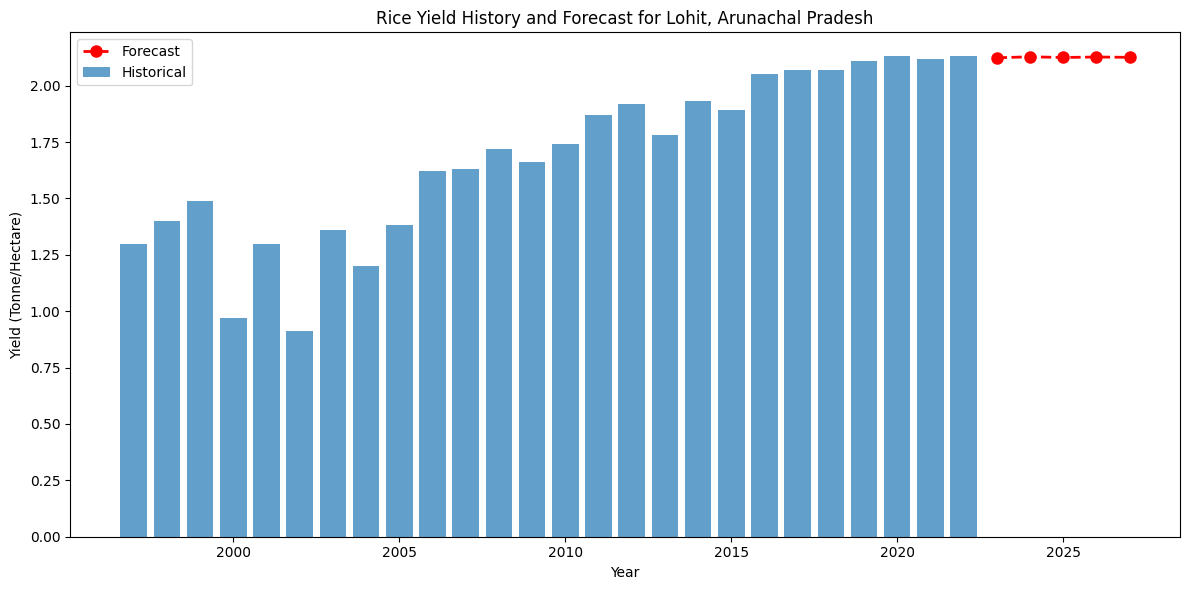


Yield Forecast for the next 5 years:
2023: 2.12 tonne/hectare
2024: 2.13 tonne/hectare
2025: 2.12 tonne/hectare
2026: 2.13 tonne/hectare
2027: 2.13 tonne/hectare


In [10]:
def main():
    try:
        file_path = "rice.xlsx"  # Replace with your file path
        print("\nLoading and preprocessing data...")
        df = load_and_preprocess_data(file_path)
        
        print("\nAgricultural Yield Analysis")
        print("----------------------------")
        state = input("Enter the state name: ")
        district = input("Enter the district name: ")
        
        data = analyze_agricultural_data(state, district, df)
        
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please check your input data and try again.")

if __name__ == "__main__":
    main()